In [28]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation
from matplotlib.colors import hsv_to_rgb
from skimage.restoration import unwrap_phase
from mpl_toolkits.axes_grid1 import AxesGrid

In [29]:
folder = "E:/Nion_PL_aberr_20231023/5_15/"
#dat4d_undist = np.load(folder + "data.npy")
#pacbed_undist = np.average(dat4d_undist, axis=(0,1))
pacbed_undist = np.load(folder + "pacbed.npy")
gray = pacbed_undist

In [30]:
from zernike import RZern
from zernike import FitZern

In [31]:
cart = RZern(4)
lgsz = 450
L, K =  lgsz,lgsz
ddx = np.linspace(-1.0, 1.0, K)
ddy = np.linspace(-1.0, 1.0, L)
xv, yv = np.meshgrid(ddx, ddy)
cart.make_cart_grid(xv, yv)

c = np.zeros(cart.nk)
Zern_list = np.zeros((cart.nk,L, K))
for i in range(0, cart.nk):
    c *= 0.0
    c[i] = 1.0
    Phi = cart.eval_grid(c, matrix=True)
    Phi[np.isnan(Phi)] = 0
    Zern_list[i] = Phi

In [32]:
imgsize = (K,K)
img_new = np.zeros(imgsize)
x_start = int(K/2-pacbed_undist.shape[0]/2)
y_start = int(K/2-pacbed_undist.shape[0]/2)
x_end = int(K/2+pacbed_undist.shape[0]/2)
y_end = int(K/2+pacbed_undist.shape[0]/2)
img_new[x_start:x_end,y_start:y_end]=pacbed_undist

In [33]:
mask = np.zeros(img_new.shape)
imgX, imgY = np.indices(img_new.shape)
x_center = img_new.shape[0]/2
y_center = img_new.shape[1]/2
mask[np.where(np.sqrt((imgX-x_center)**2+(imgY-y_center)**2)<img_new.shape[0]/2-3)] = 1
mask[np.where(np.sqrt((imgX-x_center)**2+(imgY-y_center)**2)>=img_new.shape[0]/2-3)] = 'nan'

Zernx = np.zeros((img_new.shape[0],img_new.shape[1],cart.nk))
Zerny = np.zeros((img_new.shape[0],img_new.shape[1],cart.nk))
vZernx = np.zeros((img_new.size,cart.nk))
vZerny = np.zeros((img_new.size,cart.nk))
for i in range(cart.nk):
    zernxn, zernyn = np.gradient(Zern_list[i])
    Zernx[:,:,i] = zernxn*mask
    Zerny[:,:,i] = zernyn*mask
    vZernx[:,i] = np.ravel(zernxn*mask, order='F')
    vZerny[:,i] = np.ravel(zernyn*mask, order='F')

In [34]:
def SumZern(znparams,Zern):
    Zern_sum = np.zeros(img_new.shape)
    for i in range(cart.nk):       
        Zern_sum+=znparams[i]*Zern[:,:,i]
    Zern_sum[np.isnan(Zern_sum)] = 0
    
    return Zern_sum

Text(0.5, 1.0, 'zerny')

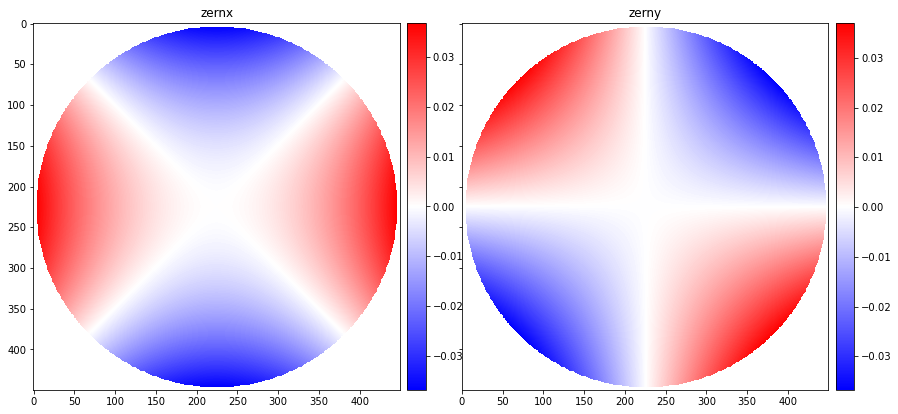

In [35]:
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(Zernx[:,:,8], cmap=plt.cm.bwr)
im2=grid[1].imshow(Zerny[:,:,8], cmap=plt.cm.bwr)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("zernx")
grid[1].set_title("zerny")

Text(0.5, 1.0, 'CBED')

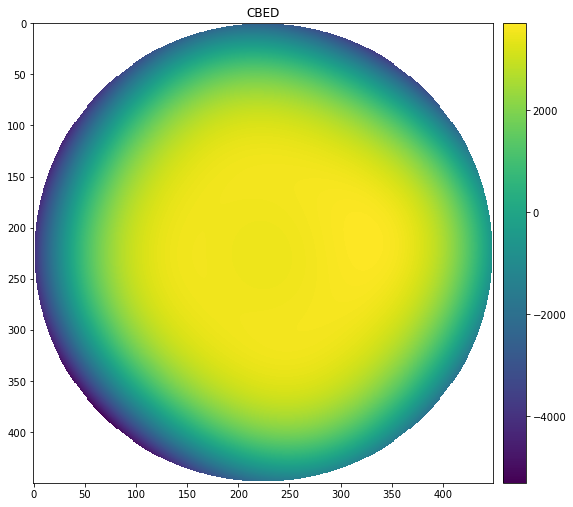

In [36]:
znparams = np.load("E:/Nion_PL_aberr_20231023/5_15/bj_znparams515_order4_450.npy")
#znparams = np.zeros(cart.nk)
#znparams[5] = 900
#znparams[4] = 900
disp_map = cart.eval_grid(znparams, matrix=True)
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(disp_map, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("CBED")

In [37]:
znparams

array([ 1616.95192692,   531.25047981,    34.44307904, -1870.4857747 ,
         194.7256443 ,     5.93141254,    18.31808595,   188.42980485,
         -59.04596342,    55.80878501,  -615.49458136,   -20.32648613,
          63.31435758,   189.78596805,  -144.75084986])

Text(0.5, 1.0, 'zerny')

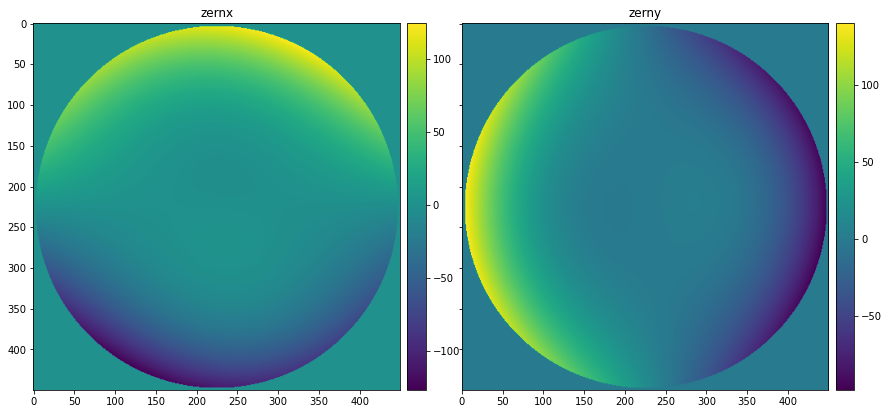

In [38]:
aber_x = SumZern(znparams,Zernx)
aber_y = SumZern(znparams,Zerny)
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(aber_x, cmap=plt.cm.viridis)
im2=grid[1].imshow(aber_y, cmap=plt.cm.viridis)
#cmap=plt.cm.bwr, vmax = 0.0045,vmin = -0.0045
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("zernx")
grid[1].set_title("zerny")

In [41]:
imgsize = img_new.shape
mapx = np.zeros(imgsize,np.float32)
mapy = np.zeros(imgsize,np.float32)
for j in range(imgsize[0]):
    for i in range(imgsize[1]):        
        mapx[i,j] = i + aber_x[i,j]*1
        mapy[i,j] = j+aber_y[i,j]*1

Text(0.5, 1.0, 'remap')

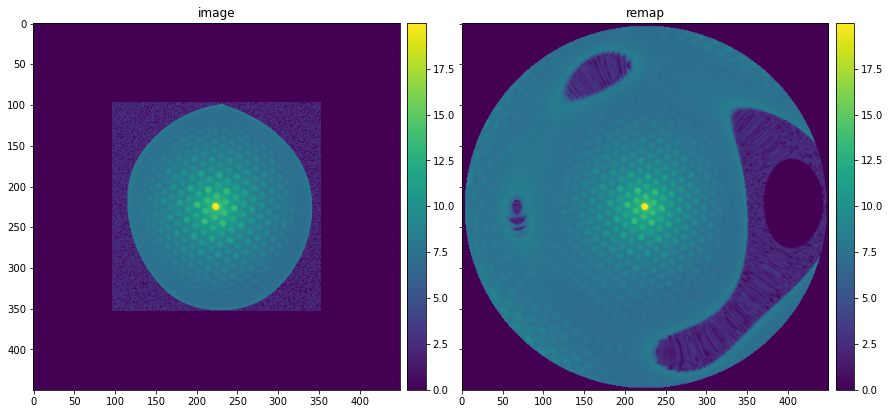

In [43]:
rst=cv2.remap(img_new,mapy,mapx,cv2.INTER_LINEAR)
fig =plt.figure(1, figsize=(50, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,2),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im1=grid[0].imshow(np.log(img_new*1e5+1), cmap=plt.cm.viridis)
im2=grid[1].imshow(np.log(rst*1e5+1), cmap=plt.cm.viridis)
#im1=grid[0].imshow(img_new*1e5+1, cmap=plt.cm.viridis)
#im2=grid[1].imshow(rst*1e5+1, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im1)
grid.cbar_axes[1].colorbar(im2)
grid[0].set_title("image")
grid[1].set_title("remap")

Text(0.5, 1.0, 'position averaged CBED')

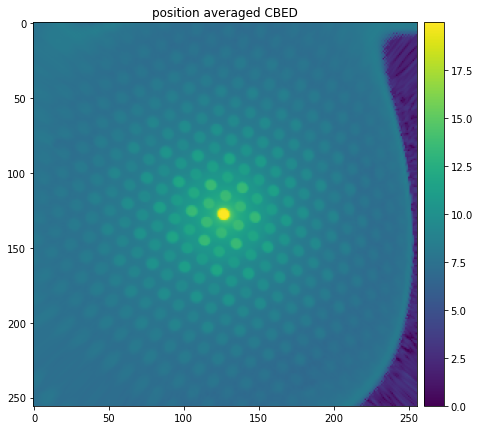

In [44]:
rst_new = rst[x_start:x_end,y_start:y_end]
zero_id = np.where(np.log(rst_new*1e10+1) <3)
rst_new[zero_id[0],zero_id[1]]=pacbed_undist.min()
fig =plt.figure(1, figsize=(25, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.log(rst_new*1e5+1), cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")

In [42]:
dat4d = np.empty(dat4d_undist.shape)
for i in range(dat4d_undist.shape[0]):
    for j in range(dat4d_undist.shape[1]):
        img_new = np.zeros(imgsize) 
        img_new[x_start:x_end,y_start:y_end]= dat4d_undist[i,j]
        dat4d_temp = cv2.remap(img_new,mapy,mapx,cv2.INTER_NEAREST)
        dat4d_s = dat4d_temp[x_start:x_end,y_start:y_end]

        dat4d[i,j] = dat4d_s

NameError: name 'dat4d_undist' is not defined

<ipython-input-41-55a2b767da98>:11: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)


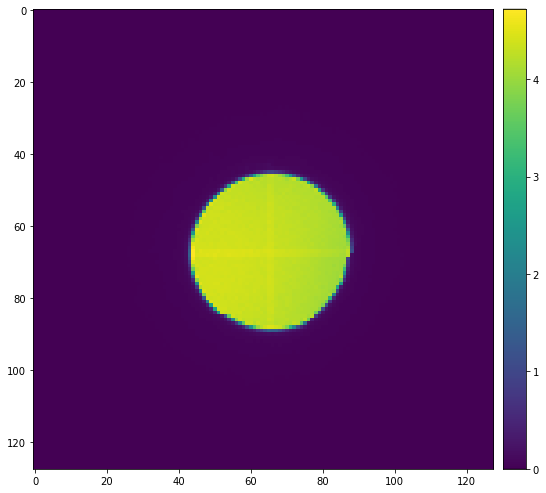

In [41]:
pacbed_new = np.average(dat4d,axis=(0,1))
fig =plt.figure(1, figsize=(30, 30))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed_new, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)

In [42]:
np.save("D:/Simu_prycho/For Shoucong/MoS2/1_corr/data.npy", np.float32(dat4d))